# Cars Brand Image Classification using CNN

## Import libraries

In [45]:
import os
import zipfile
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import glob
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

#from tensorflow.keras.preprocessing.image import load_img ,img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers.legacy import RMSprop

## Loading data

In [2]:
# Delete the data and models folder if it exists
!rm -Rf data
!rm -Rf models

In [3]:
# Unpacking files from the zip archive

with zipfile.ZipFile("archive.zip","r") as zip_ref:
    zip_ref.extractall("data")

In [4]:
# Creating directories for training and test files

location = 'data'
directories = ['images', 'images/train', 'images/test']
for directory in directories:
    os.mkdir(os.path.join(location, directory))

In [5]:
# Creating classes of car brands and dividing the files into 80% training and 20% testing

path = 'data/imgs_zip/imgs/'

for class_ in os.listdir(path)[:5]:
    #print(str(class_))
    os.mkdir('data/images/train/'+class_)
    os.mkdir('data/images/test/'+class_)
    
    data = os.listdir(path+class_)
    for img in itertools.islice(glob.iglob(os.path.join(path+class_, '*jpg')), 
                                 len(data[:round(len(data)*0.8)])):
        shutil.copy(img, 'data/images/train/'+class_)
        
    for img in itertools.islice(glob.iglob(os.path.join(path+class_, '*jpg')), 
                                 len(data[:round(len(data)*0.8)]), len(data)):
        shutil.copy(img, 'data/images/test/'+class_)

## Data mining

In [6]:
# Listing the names of car brand folders from the train folder

os.listdir('data/images/train')

['Audi', 'Hudson', 'Mercedes-Benz', 'Lincoln', 'Bugatti']

In [7]:
# Listing the names of car brand folders from the train folder

os.listdir('data/images/test')

['Audi', 'Hudson', 'Mercedes-Benz', 'Lincoln', 'Bugatti']

In [8]:
# Listing of file names from the sample training folder

os.listdir('data/images/train/'+class_)

['Bugatti_061.jpg',
 'Bugatti_049.jpg',
 'Bugatti_015.jpg',
 'Bugatti_029.jpg',
 'Bugatti_000.jpg',
 'Bugatti_034.jpg',
 'Bugatti_083.jpg',
 'Bugatti_087.jpg',
 'Bugatti_048.jpg',
 'Bugatti_059.jpg',
 'Bugatti_072.jpg',
 'Bugatti_066.jpg',
 'Bugatti_023.jpg',
 'Bugatti_084.jpg',
 'Bugatti_078.jpg',
 'Bugatti_075.jpg',
 'Bugatti_091.jpg',
 'Bugatti_041.jpg',
 'Bugatti_002.jpg',
 'Bugatti_043.jpg',
 'Bugatti_085.jpg',
 'Bugatti_081.jpg',
 'Bugatti_016.jpg',
 'Bugatti_020.jpg',
 'Bugatti_037.jpg',
 'Bugatti_018.jpg',
 'Bugatti_058.jpg',
 'Bugatti_022.jpg',
 'Bugatti_038.jpg',
 'Bugatti_071.jpg',
 'Bugatti_068.jpg',
 'Bugatti_086.jpg',
 'Bugatti_047.jpg',
 'Bugatti_032.jpg',
 'Bugatti_040.jpg',
 'Bugatti_062.jpg',
 'Bugatti_012.jpg',
 'Bugatti_070.jpg',
 'Bugatti_027.jpg',
 'Bugatti_050.jpg',
 'Bugatti_080.jpg',
 'Bugatti_067.jpg',
 'Bugatti_017.jpg',
 'Bugatti_003.jpg',
 'Bugatti_010.jpg',
 'Bugatti_014.jpg',
 'Bugatti_088.jpg',
 'Bugatti_039.jpg',
 'Bugatti_019.jpg',
 'Bugatti_060.jpg',


(-0.5, 288.5, 174.5, -0.5)

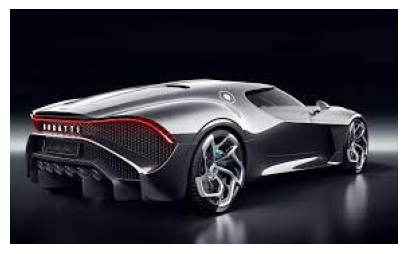

In [9]:
# Listing a sample car image
 
img = image.load_img('data/images/train/'+class_+'/'+data[0])

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

## Data augmentation

In [10]:
# Generate batches of tensor image data with real-time data augmentation

train_datagen = ImageDataGenerator(
     rotation_range=30, # angle range by which the images will randomly rotate
     rescale=1./255.,
     width_shift_range=0.1, # vertical image transformations
     height_shift_range=0.1, # horizontal image transformations
     shear_range=0.1, # random image cropping range
     zoom_range=0.2, # random image zoom range
     horizontal_flip=True, # random flip of half the image in the horizontal plane
     fill_mode='nearest' # strategy for filling newly created pixels that may result from transformations
)

train_gen = train_datagen.flow_from_directory('data/images/train',
                                              target_size=(128, 128),
                                              batch_size=32,
                                              class_mode='categorical')
test_gen = ImageDataGenerator().flow_from_directory('data/images/test',
                                                    target_size=(128, 128),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 377 images belonging to 5 classes.
Found 93 images belonging to 5 classes.


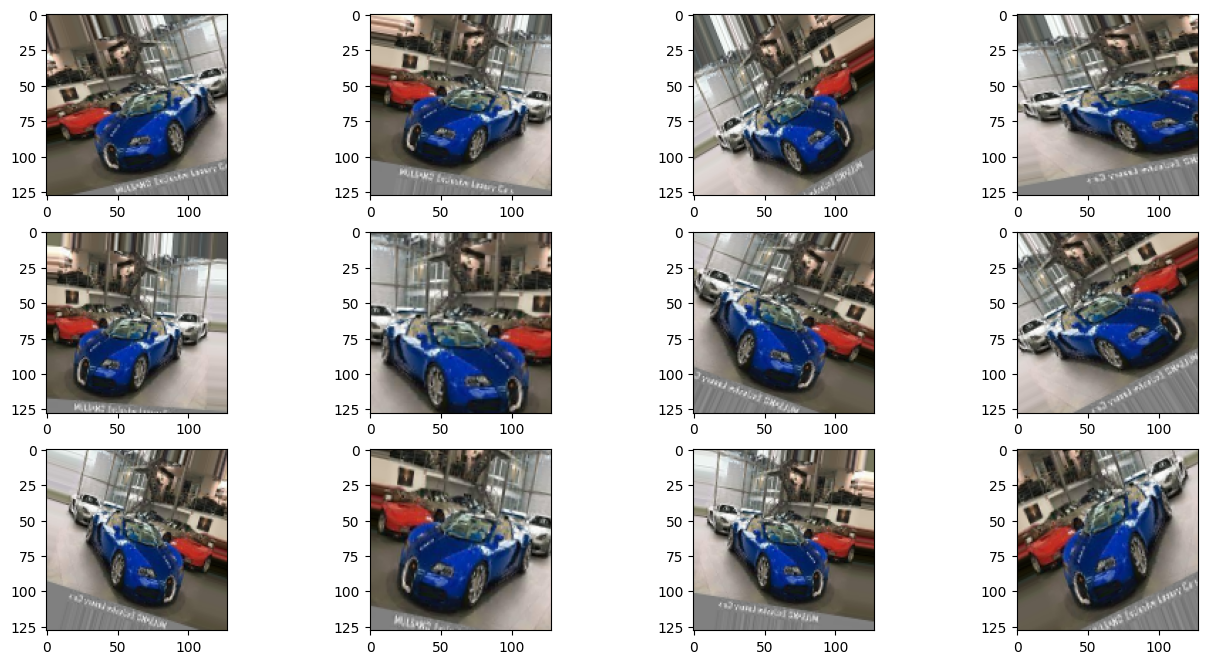

In [11]:
# Sample images obtained using the technique data augmentation

img = image.load_img('data/images/train/'+class_+'/'+data[10],target_size=(128, 128))# plt.imshow(img)
#img = image.load_img(img_path, target_size=(128, 128))

x = image.img_to_array(img)
x = x.reshape((1, ) + x.shape)

i = 1
plt.figure(figsize=(16, 8))
for batch in train_datagen.flow(x, batch_size=1):
    plt.subplot(3, 4, i)
    plt.grid(False)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 13 == 0:
        break

##  Model construction

In [12]:
# Create function to plot model history information

def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    #fig.title('VGG16')
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoch', yaxis_title='Loss', yaxis_type='log')
    fig.show()

### CNN

In [14]:
model = models.Sequential()
model.add(layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                  activation ='relu', input_shape = (128, 128,3)))
model.add(layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))


model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(layers.Dropout(0.25))


model.add(layers.Flatten())
model.add(layers.Dense(256, activation = "relu"))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation = "softmax"))
model.compile(loss=categorical_crossentropy, optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

2023-10-31 10:02:19.714682: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 10:02:19.727208: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
history = model.fit(train_gen, validation_data=test_gen, batch_size=128, epochs=20)

Epoch 1/20
12/12 [==============================] - 9s 712ms/step - loss: 1.8837 - accuracy: 0.2281 - val_loss: 17.1875 - val_accuracy: 0.2043
Epoch 2/20
12/12 [==============================] - 8s 695ms/step - loss: 1.6175 - accuracy: 0.2334 - val_loss: 68.2819 - val_accuracy: 0.2151
Epoch 3/20
12/12 [==============================] - 8s 688ms/step - loss: 1.6341 - accuracy: 0.2308 - val_loss: 7.1692 - val_accuracy: 0.1720
Epoch 4/20
12/12 [==============================] - 8s 690ms/step - loss: 1.6405 - accuracy: 0.2440 - val_loss: 7.1481 - val_accuracy: 0.2151
Epoch 5/20
12/12 [==============================] - 8s 688ms/step - loss: 1.6045 - accuracy: 0.2599 - val_loss: 5.8499 - val_accuracy: 0.2473
Epoch 6/20
12/12 [==============================] - 8s 691ms/step - loss: 1.8368 - accuracy: 0.2149 - val_loss: 25.7205 - val_accuracy: 0.1828
Epoch 7/20
12/12 [==============================] - 8s 692ms/step - loss: 1.6025 - accuracy: 0.2599 - val_loss: 19.1914 - val_accuracy: 0.2903
Ep

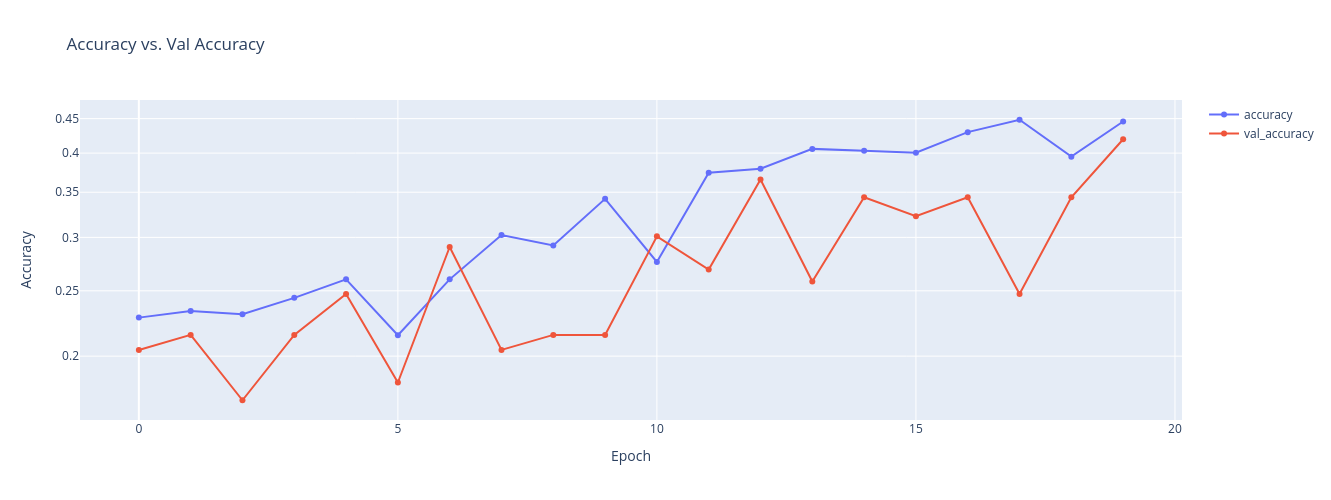

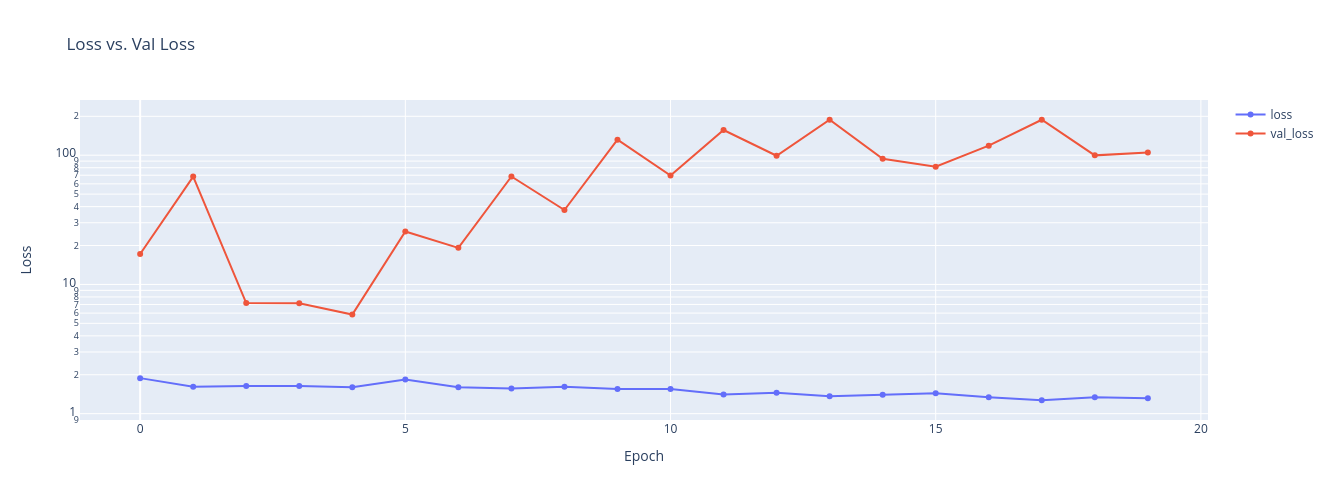

In [16]:
plot_hist(history)

In [17]:
os.mkdir('models')

In [18]:
model.save('models/cnn_model_5.h5')

/home/marcin/.virtualenvs/ds2/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



### Vgg16

In [19]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
conv_base.trainable = False

In [20]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])
#model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-5),
             # loss='categorical_crossentropy',
             # metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 16813381 (64.14 MB)
Trainable params: 2098693 (8.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [21]:
history = model.fit(train_gen, validation_data=test_gen, batch_size=128, epochs=20)

Epoch 1/20
12/12 [==============================] - 8s 605ms/step - loss: 2.3513 - accuracy: 0.2387 - val_loss: 18.1343 - val_accuracy: 0.3656
Epoch 2/20
12/12 [==============================] - 7s 589ms/step - loss: 1.3626 - accuracy: 0.4324 - val_loss: 19.2723 - val_accuracy: 0.4409
Epoch 3/20
12/12 [==============================] - 7s 588ms/step - loss: 1.1143 - accuracy: 0.5385 - val_loss: 20.6427 - val_accuracy: 0.5376
Epoch 4/20
12/12 [==============================] - 7s 589ms/step - loss: 1.0192 - accuracy: 0.5995 - val_loss: 24.4707 - val_accuracy: 0.5054
Epoch 5/20
12/12 [==============================] - 7s 589ms/step - loss: 0.9225 - accuracy: 0.6578 - val_loss: 24.8860 - val_accuracy: 0.5161
Epoch 6/20
12/12 [==============================] - 7s 595ms/step - loss: 0.8233 - accuracy: 0.6658 - val_loss: 27.7950 - val_accuracy: 0.5376
Epoch 7/20
12/12 [==============================] - 7s 606ms/step - loss: 0.7854 - accuracy: 0.7135 - val_loss: 28.7737 - val_accuracy: 0.5161

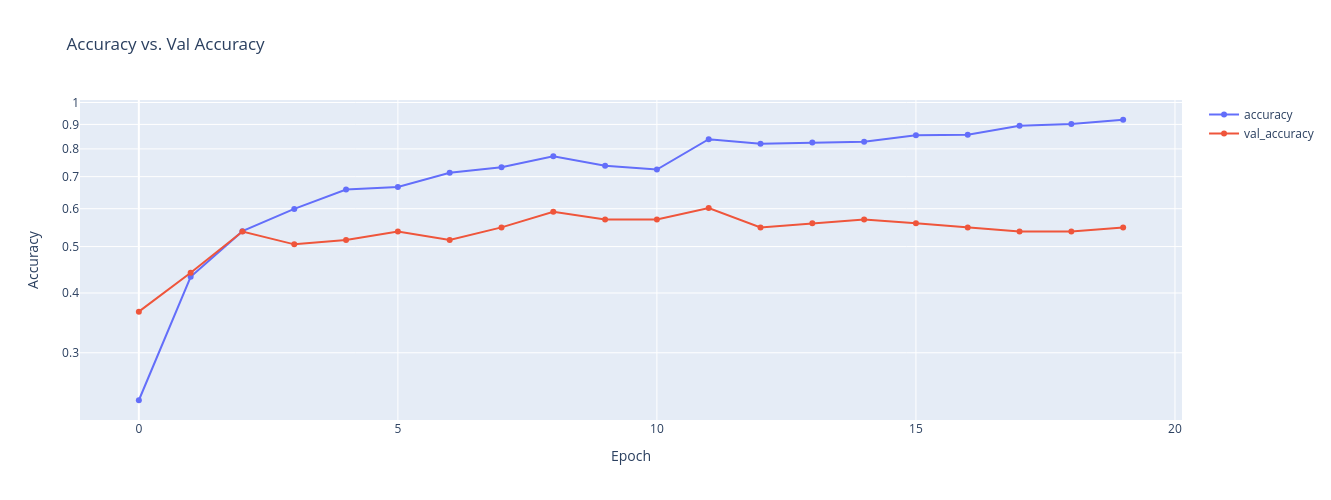

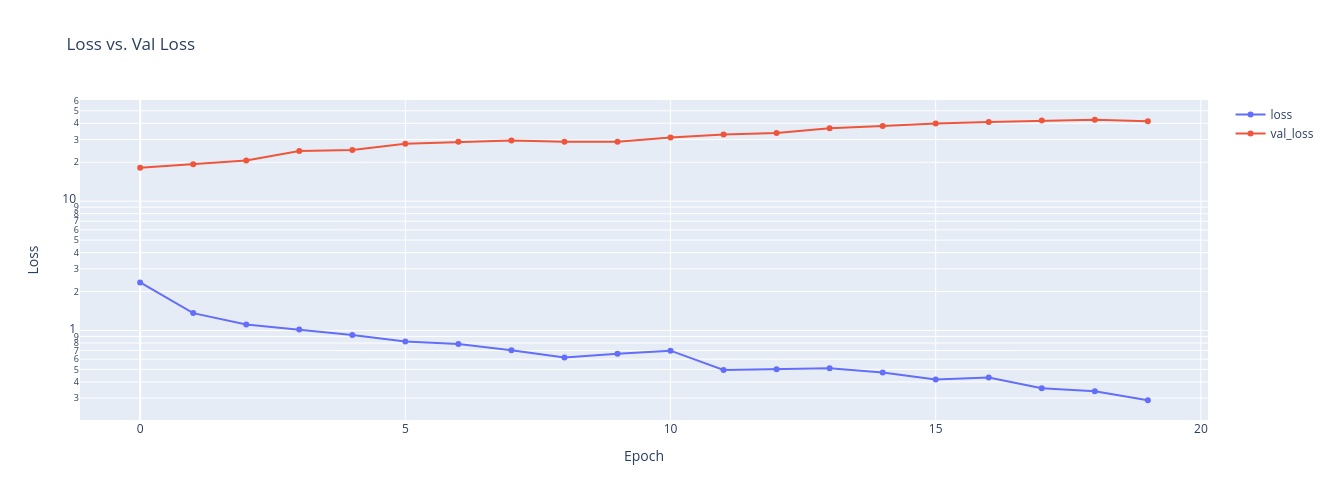

In [22]:
plot_hist(history)

In [23]:
model.save('models/vgg16_model_5.h5')

/home/marcin/.virtualenvs/ds2/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



### ResNet50

In [24]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
conv_base.trainable = False

In [25]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])
#model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-5),
             # loss='categorical_crossentropy',
             # metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               8388864   
                                                                 
 dense_5 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 31977861 (121.99 MB)
Trainable params: 8390149 (32.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [26]:
history = model.fit(train_gen, validation_data=test_gen, batch_size=128, epochs=20)

Epoch 1/20
12/12 [==============================] - 7s 435ms/step - loss: 2.7602 - accuracy: 0.1989 - val_loss: 3.6044 - val_accuracy: 0.1828
Epoch 2/20
12/12 [==============================] - 4s 357ms/step - loss: 1.7959 - accuracy: 0.1910 - val_loss: 3.9866 - val_accuracy: 0.2258
Epoch 3/20
12/12 [==============================] - 4s 363ms/step - loss: 1.6008 - accuracy: 0.2626 - val_loss: 3.8117 - val_accuracy: 0.2043
Epoch 4/20
12/12 [==============================] - 4s 359ms/step - loss: 1.5591 - accuracy: 0.2785 - val_loss: 4.1501 - val_accuracy: 0.1935
Epoch 5/20
12/12 [==============================] - 4s 356ms/step - loss: 1.5140 - accuracy: 0.3528 - val_loss: 4.6884 - val_accuracy: 0.1935
Epoch 6/20
12/12 [==============================] - 4s 357ms/step - loss: 1.5428 - accuracy: 0.3210 - val_loss: 5.4275 - val_accuracy: 0.2366
Epoch 7/20
12/12 [==============================] - 4s 361ms/step - loss: 1.5073 - accuracy: 0.3475 - val_loss: 6.4851 - val_accuracy: 0.2151
Epoch 

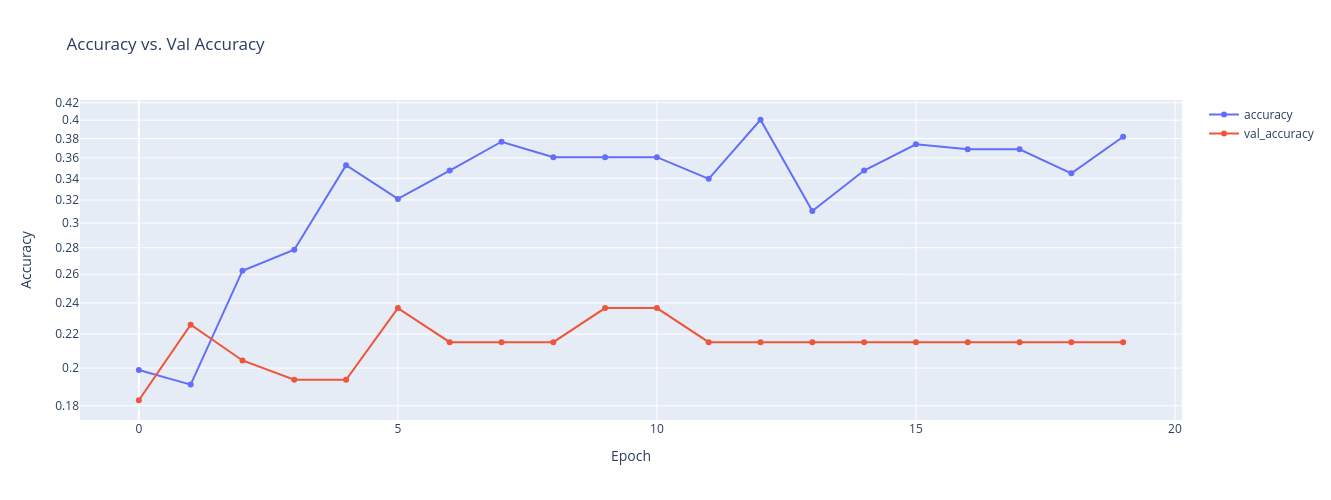

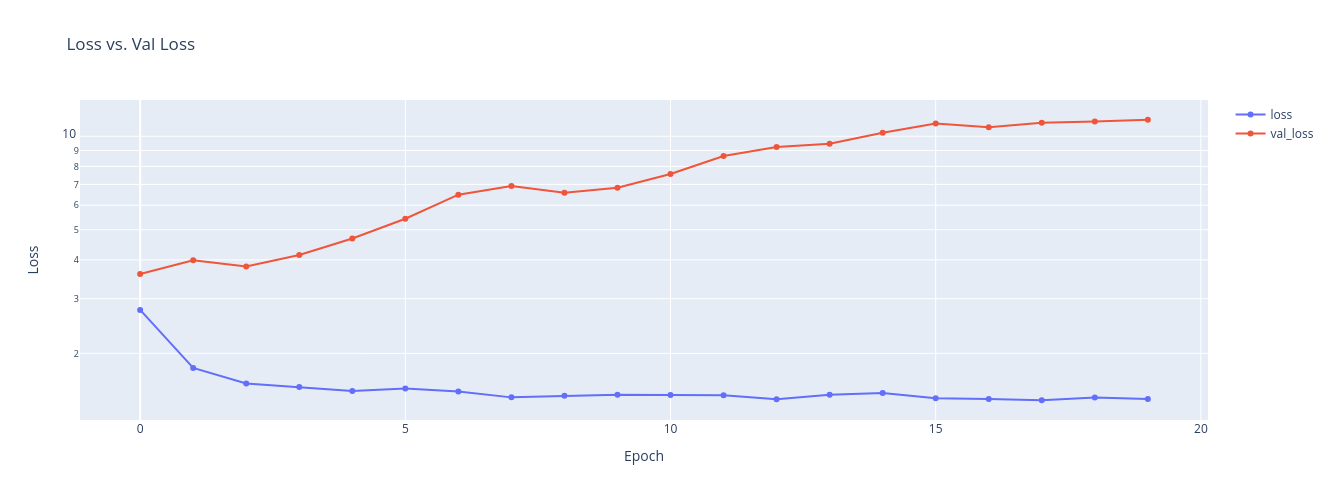

In [27]:
plot_hist(history)

In [28]:
model.save('models/resnet50_model_5.h5')

/home/marcin/.virtualenvs/ds2/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



### InceptionV3

In [29]:
conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
conv_base.trainable = False

In [30]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])
#model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-5),
             # loss='categorical_crossentropy',
             # metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               2097408   
                                                                 
 dense_7 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 23901477 (91.18 MB)
Trainable params: 2098693 (8.01 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [31]:
history = model.fit(train_gen, validation_data=test_gen, batch_size=128, epochs=20)

Epoch 1/20
12/12 [==============================] - 6s 255ms/step - loss: 9.2284 - accuracy: 0.2255 - val_loss: 102.3165 - val_accuracy: 0.2151
Epoch 2/20
12/12 [==============================] - 2s 147ms/step - loss: 2.0578 - accuracy: 0.4085 - val_loss: 31.0014 - val_accuracy: 0.2903
Epoch 3/20
12/12 [==============================] - 2s 148ms/step - loss: 1.2395 - accuracy: 0.5066 - val_loss: 31.8843 - val_accuracy: 0.2473
Epoch 4/20
12/12 [==============================] - 2s 149ms/step - loss: 1.1324 - accuracy: 0.5252 - val_loss: 30.3649 - val_accuracy: 0.2796
Epoch 5/20
12/12 [==============================] - 2s 152ms/step - loss: 1.0115 - accuracy: 0.5942 - val_loss: 22.3785 - val_accuracy: 0.2366
Epoch 6/20
12/12 [==============================] - 2s 148ms/step - loss: 0.9603 - accuracy: 0.6286 - val_loss: 57.5297 - val_accuracy: 0.2796
Epoch 7/20
12/12 [==============================] - 2s 148ms/step - loss: 0.9444 - accuracy: 0.6366 - val_loss: 40.6953 - val_accuracy: 0.279

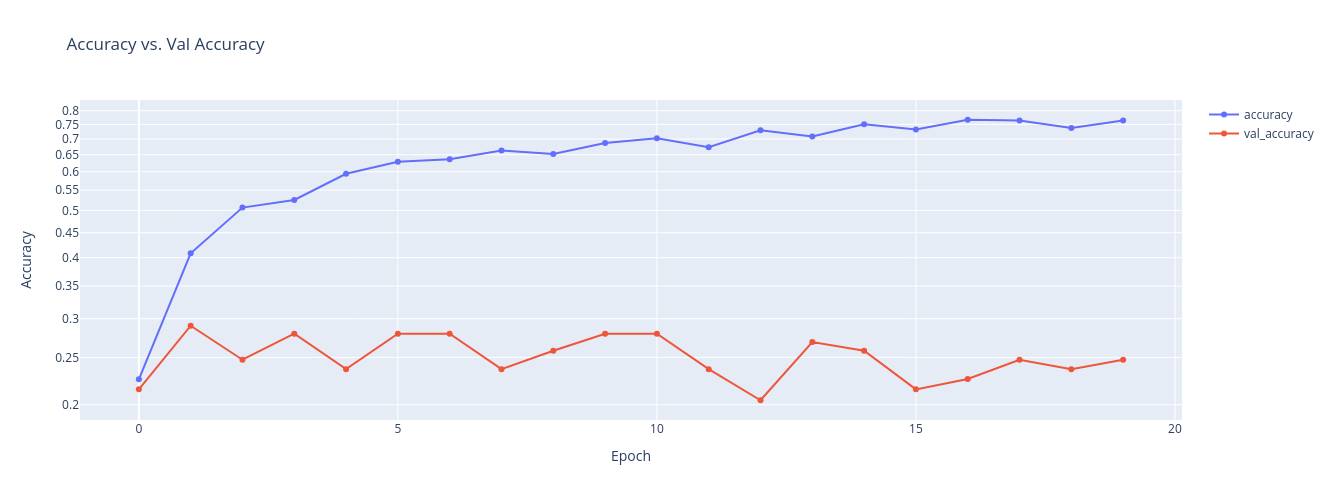

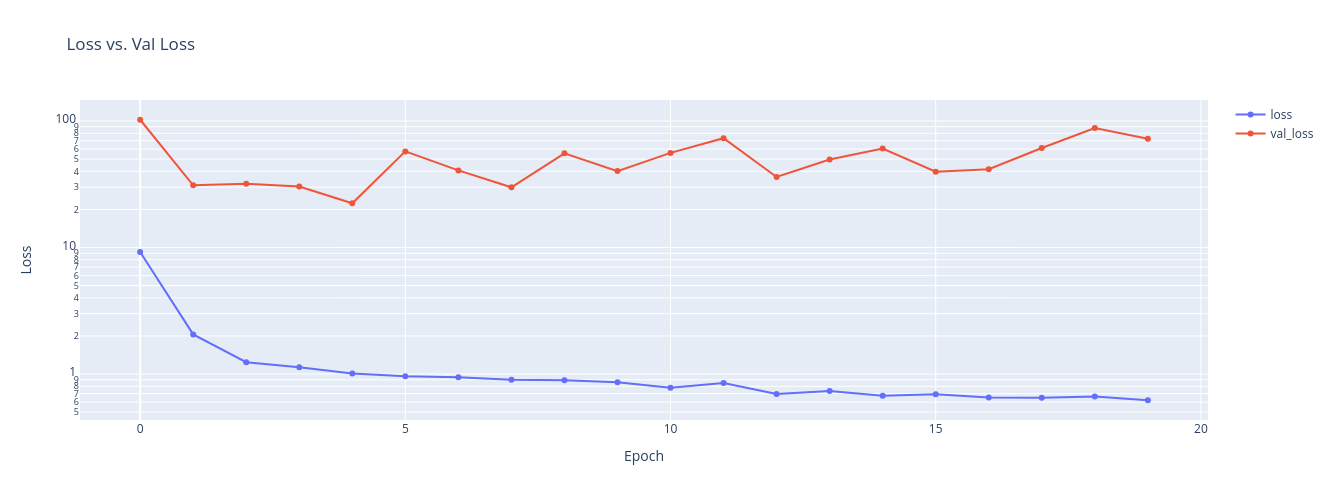

In [32]:
plot_hist(history)

In [33]:
model.save('models/inceptionv3_model_5.h5')

/home/marcin/.virtualenvs/ds2/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



## Evaluation of models on the test set

In [34]:
# Preparation of test data

test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    'data/images/test',
    target_size=(128, 128),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 93 images belonging to 5 classes.


In [35]:
# Raad class indices

test_generator.class_indices

{'Audi': 0, 'Bugatti': 1, 'Hudson': 2, 'Lincoln': 3, 'Mercedes-Benz': 4}

In [43]:
classes = list(test_generator.class_indices.keys())

In [36]:
# Show input test data class matrix
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4], dtype=int32)

In [37]:
# Load models
cnn_model = load_model('models/cnn_model_5.h5')
vgg_model = load_model('models/vgg16_model_5.h5')
resnet_model = load_model('models/resnet50_model_5.h5')
inc_model = load_model('models/inceptionv3_model_5.h5')

### CNN

In [38]:
# Predict cnn model

y_prob = cnn_model.predict(test_generator, test_generator.samples)

93/93 [==============================] - 1s 8ms/step


In [39]:
y_pred_cnn = np.argmax(y_prob, axis=1)

In [40]:
# Show confusion matrix

cm = confusion_matrix(y_true, y_pred_cnn)
cm

array([[ 4,  3,  0,  6,  4],
       [ 1,  8,  0,  2,  7],
       [ 2,  1, 12,  1,  4],
       [ 2,  3,  4,  3,  8],
       [ 0,  2,  1,  8,  7]])

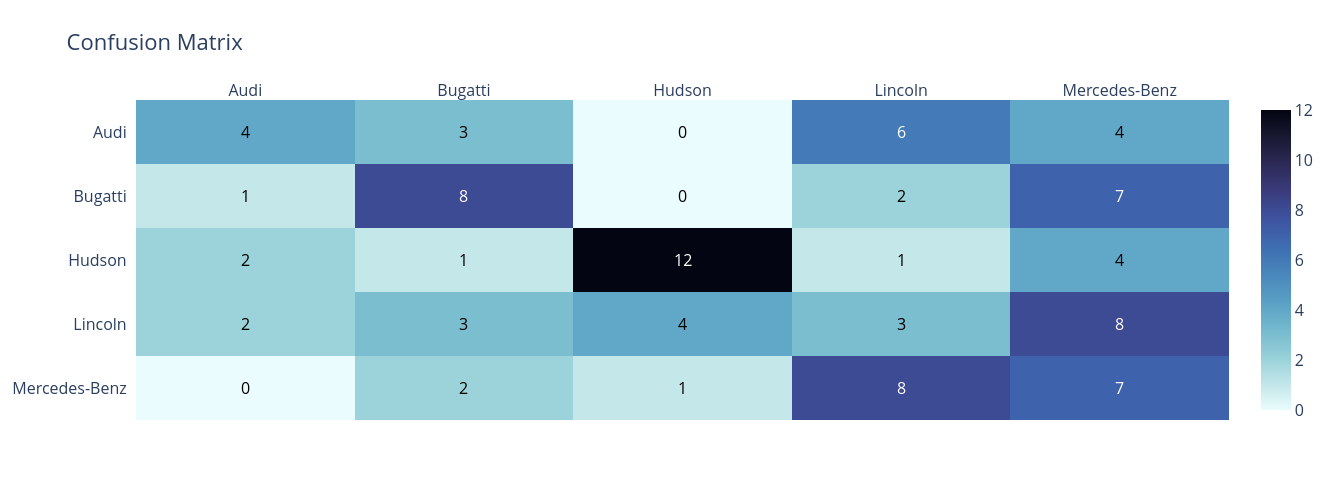

In [46]:
def plot_confusion_matrix(cm):
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=classes, index=classes[::-1])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index), colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=500, height=500, title='Confusion Matrix', font_size=16)
    fig.show()

plot_confusion_matrix(cm)

In [47]:
print(classification_report(y_true, y_pred_cnn, target_names=test_generator.class_indices.keys()))

               precision    recall  f1-score   support

         Audi       0.44      0.24      0.31        17
      Bugatti       0.47      0.44      0.46        18
       Hudson       0.71      0.60      0.65        20
      Lincoln       0.15      0.15      0.15        20
Mercedes-Benz       0.23      0.39      0.29        18

     accuracy                           0.37        93
    macro avg       0.40      0.36      0.37        93
 weighted avg       0.40      0.37      0.37        93



### VGG16

In [48]:
# Predict model

y_prob = vgg_model.predict(test_generator, test_generator.samples)

93/93 [==============================] - 2s 21ms/step


In [49]:
y_pred_vgg = np.argmax(y_prob, axis=1)

In [50]:
# Show confusion matrix

cm = confusion_matrix(y_true, y_pred_vgg)
cm

array([[14,  0,  0,  1,  2],
       [ 2, 13,  1,  2,  0],
       [ 2,  0, 11,  6,  1],
       [ 1,  0,  3, 12,  4],
       [ 2,  1,  0,  4, 11]])

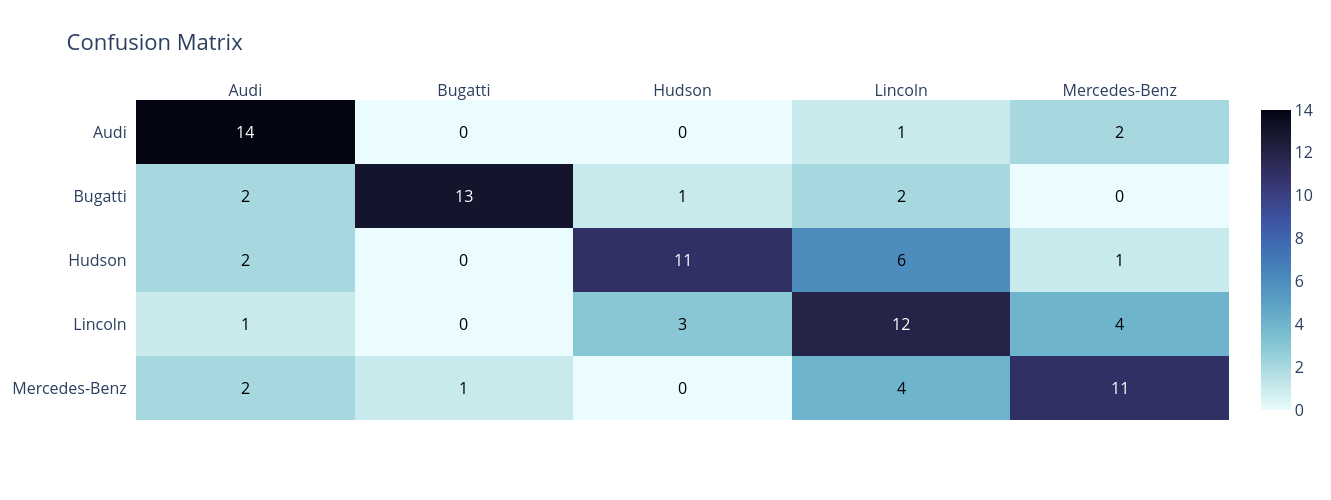

In [51]:
plot_confusion_matrix(cm)

In [52]:
print(classification_report(y_true, y_pred_vgg, target_names=test_generator.class_indices.keys()))

               precision    recall  f1-score   support

         Audi       0.67      0.82      0.74        17
      Bugatti       0.93      0.72      0.81        18
       Hudson       0.73      0.55      0.63        20
      Lincoln       0.48      0.60      0.53        20
Mercedes-Benz       0.61      0.61      0.61        18

     accuracy                           0.66        93
    macro avg       0.68      0.66      0.66        93
 weighted avg       0.68      0.66      0.66        93



## ResNet50

In [53]:
# Predict model

y_prob = resnet_model.predict(test_generator, test_generator.samples)

93/93 [==============================] - 2s 19ms/step


In [54]:
y_pred_res = np.argmax(y_prob, axis=1)

In [55]:
# Show confusion matrix

cm = confusion_matrix(y_true, y_pred_res)
cm

array([[12,  1,  1,  3,  0],
       [11,  3,  0,  2,  2],
       [ 8,  1,  7,  3,  1],
       [ 8,  0,  5,  6,  1],
       [ 6,  2,  0,  4,  6]])

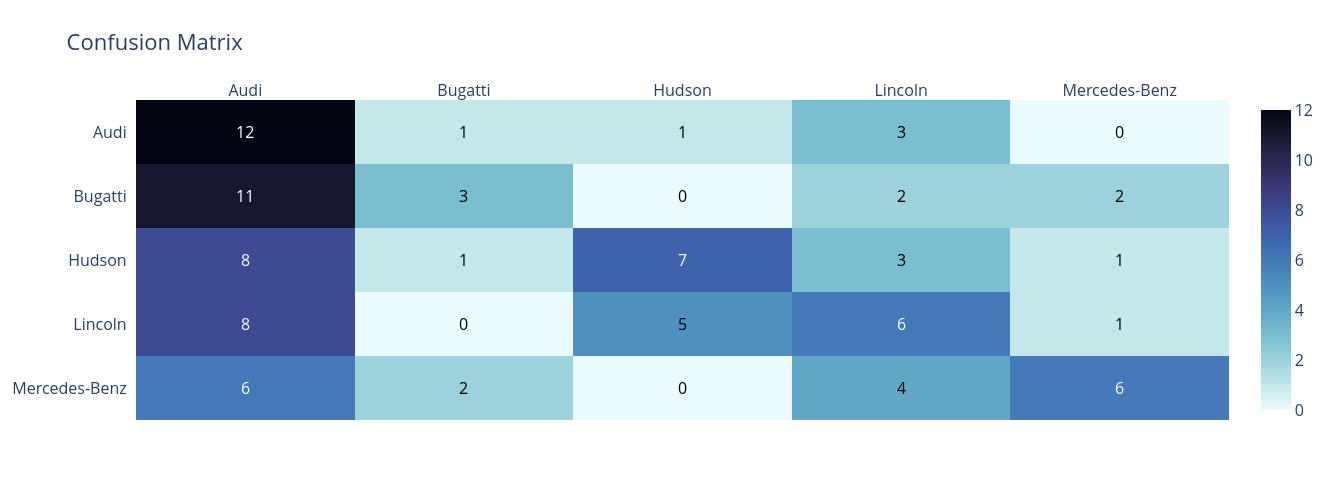

In [56]:
plot_confusion_matrix(cm)

In [57]:
print(classification_report(y_true, y_pred_res, target_names=test_generator.class_indices.keys()))

               precision    recall  f1-score   support

         Audi       0.27      0.71      0.39        17
      Bugatti       0.43      0.17      0.24        18
       Hudson       0.54      0.35      0.42        20
      Lincoln       0.33      0.30      0.32        20
Mercedes-Benz       0.60      0.33      0.43        18

     accuracy                           0.37        93
    macro avg       0.43      0.37      0.36        93
 weighted avg       0.44      0.37      0.36        93



### InceptionV3

In [58]:
# Predict model

y_prob = inc_model.predict(test_generator, test_generator.samples)

93/93 [==============================] - 2s 10ms/step


In [59]:
y_pred_inc = np.argmax(y_prob, axis=1)

In [60]:
# Show confusion matrix

cm = confusion_matrix(y_true, y_pred_inc)
cm

array([[ 3,  1,  1, 10,  2],
       [ 1, 10,  1,  3,  3],
       [ 1,  3, 10,  6,  0],
       [ 0,  2,  4, 14,  0],
       [ 2,  1,  0, 13,  2]])

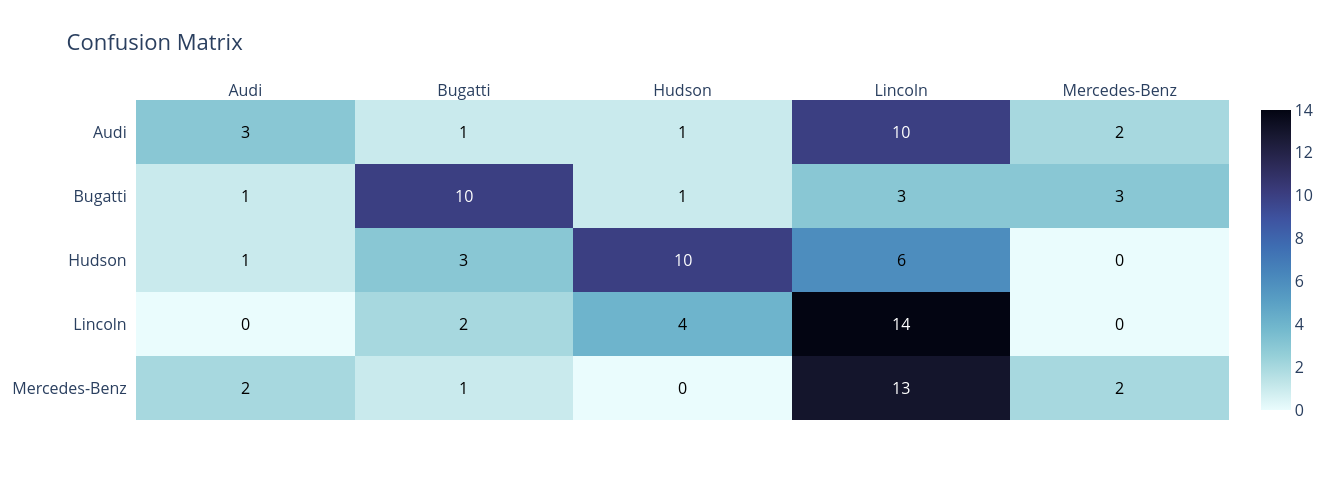

In [61]:
plot_confusion_matrix(cm)

In [62]:
print(classification_report(y_true, y_pred_inc, target_names=test_generator.class_indices.keys()))

               precision    recall  f1-score   support

         Audi       0.43      0.18      0.25        17
      Bugatti       0.59      0.56      0.57        18
       Hudson       0.62      0.50      0.56        20
      Lincoln       0.30      0.70      0.42        20
Mercedes-Benz       0.29      0.11      0.16        18

     accuracy                           0.42        93
    macro avg       0.45      0.41      0.39        93
 weighted avg       0.45      0.42      0.40        93



## Summary

Analyzing the obtained result, the best results are obtained by the VGG16 model, as evidenced by an accuracy of 0.68 and an f1-score of 0.68

In [69]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred_vgg}, index=test_generator.filenames)
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred'])
print('Errors in all test files (91):')
errors['is_incorrect'].sum()

Errors in all test files (91):


32

In [70]:
errors

y_true  y_pred  is_incorrect
Audi/Audi_004.jpg                         0       0         False
Audi/Audi_006.jpg                         0       0         False
Audi/Audi_013.jpg                         0       3          True
Audi/Audi_014.jpg                         0       0         False
Audi/Audi_015.jpg                         0       0         False
...                                     ...     ...           ...
Mercedes-Benz/Mercedes-Benz_056.jpg       4       1          True
Mercedes-Benz/Mercedes-Benz_068.jpg       4       0          True
Mercedes-Benz/Mercedes-Benz_077.jpg       4       4         False
Mercedes-Benz/Mercedes-Benz_086.jpg       4       3          True
Mercedes-Benz/Mercedes-Benz_087.jpg       4       4         False

[93 rows x 3 columns]

1/1 [==============================] - 0s 32ms/step
{'Class': 'Audi', 'Probability': 0.47175083}


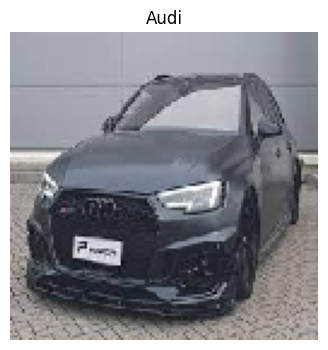

In [72]:
# Correct prediction

img_path = os.path.join('data/images/test', errors.index[3])
img = image.load_img(img_path)
new_img = image.load_img(img_path, target_size=(128, 128))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

img_class = vgg_model.predict(img)
img_class_index =np.argmax(img_class)
classname = classes[img_class_index]
prediction = vgg_model.predict(img).max()

pred_dict = {"Class":classname, "Probability":prediction}
print(pred_dict)

#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(classname)
plt.show()

1/1 [==============================] - 0s 32ms/step
{'Class': 'Lincoln', 'Probability': 0.4927967}


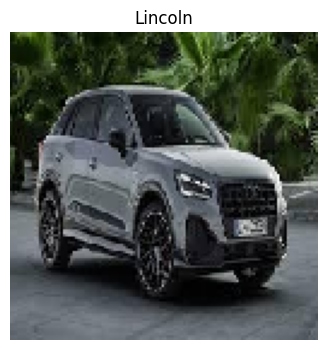

In [74]:
# Inorrect prediction

img_path = os.path.join('data/images/test', errors.index[2])
img = image.load_img(img_path)
new_img = image.load_img(img_path, target_size=(128, 128))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

img_class = vgg_model.predict(img)
img_class_index =np.argmax(img_class)
classname = classes[img_class_index]
prediction = vgg_model.predict(img).max()

pred_dict = {"Class":classname, "Probability":prediction}
print(pred_dict)

#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(classname)
plt.show()